# **Sparse Autoencoder for Analyzing BrainBERT Embeddings**

This notebook implements a sparse autoencoder to analyze BrainBERT embeddings, extract hidden layer activations, cluster neuron activations, and generate saliency maps for seizure and non-seizure embeddings.

## **BrainBERT Embeddings**

**BrainBERT** is a specialized vision transformer model designed to analyze SEEG (stereo-electroencephalography) data. It processes spectrograms—representations of the frequency components of neural signals over time—to generate dense vector embeddings. These embeddings encapsulate complex neural activity patterns, making them useful for distinguishing between seizure and non-seizure states.

The insights gained from analyzing these embeddings can shed light on the physiological mechanisms underlying seizures.

For more details, refer to the [original BrainBERT paper](https://arxiv.org/abs/2302.14367).

## **Motivation**

I undertook this project because, while current models excel at detecting seizures, there is limited research on predicting them. Furthermore, there is no research on how these models detect seizures.

My interest in epilepsy is personal, as it affects my family, and I've long wanted to develop an algorithm to predict seizures before they occur, potentially preventing harm to patients.

This research is crucial because it aims to understand how models detect seizures and what features they focus on. By applying interpretability methods to the embeddings, I hope to uncover key biomarkers that can detect (and later predict) seizures by linking features to their physiological mechanisms.

This project marks the beginning of that effort.

# Import Libraries

In [ ]:
# Install Necessary Packages
# !pip install torch scikit-learn numpy matplotlib captum

# Import Necessary Libraries
import torch
import os
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from captum.attr import Saliency

# Define the Custom Sparse Autoencoder Class
Here, a custom Sparse Autoencoder class is defined, which includes methods for initializing weights and calculating the loss function.

In [ ]:
# Define the Custom Sparse Autoencoder Class
class SparseAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SparseAutoencoder, self).__init__()

        # Encoder: Linear layer followed by LeakyReLU activation
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU()
        )

        # Decoder: Linear layer followed by LeakyReLU activation
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            nn.LeakyReLU()
        )

        # Initialize weights using Xavier uniform initialization
        self.initialize_weights()

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def loss_function(self, recon_x, x):
        mse_loss = nn.MSELoss()(recon_x, x)
        sparsity_loss = torch.mean(torch.abs(self.encoder[0].weight))
        return mse_loss + 1e-4 * sparsity_loss

# Load and Process BrainBERT Embeddings
In this section, precomputed BrainBERT embeddings are loaded and normalized.

In [ ]:
# Load and Process BrainBERT Embeddings
embeddings_save_path = "/home/vineetreddy/brainbert_embeddings.npy"
labels_save_path = "/home/vineetreddy/brainbert_labels.npy"
model_save_path = "/home/vineetreddy/sparse_autoencoder.pth"

if not os.path.exists(embeddings_save_path) or not os.path.exists(labels_save_path):
    raise FileNotFoundError("Error: The embeddings or labels files do not exist at the specified paths.")
else:
    all_brainbert_outs = np.load(embeddings_save_path)
    all_labels = np.load(labels_save_path)
    print("Loaded embeddings and labels from saved files.")

scaler = StandardScaler()
all_brainbert_outs_normalized = scaler.fit_transform(all_brainbert_outs)
brainbert_embeddings_tensor = torch.tensor(all_brainbert_outs_normalized, dtype=torch.float32)



Loaded embeddings and labels from saved files.


# Initialize and Train the Sparse Autoencoder
This section involves initializing the sparse autoencoder and training it if a saved model is not available.

In [ ]:
# Initialize and Train the Sparse Autoencoder
torch.cuda.empty_cache()

input_size = brainbert_embeddings_tensor.shape[1]
hidden_size = 256

sparse_autoencoder = SparseAutoencoder(input_size=input_size, hidden_size=hidden_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sparse_autoencoder.to(device)
brainbert_embeddings_tensor = brainbert_embeddings_tensor.to(device)

if os.path.exists(model_save_path):
    print("Model file found. Loading the model...")
    sparse_autoencoder.load_state_dict(torch.load(model_save_path))
else:
    print("No model file found. Training a new sparse autoencoder...")

    optimizer = optim.Adam(sparse_autoencoder.parameters(), lr=1e-4)
    torch.cuda.empty_cache()
    batch_size = 512
    accumulation_steps = 4
    num_batches = brainbert_embeddings_tensor.size(0) // batch_size
    epochs = 100

    for epoch in range(epochs):
        sparse_autoencoder.train()
        optimizer.zero_grad()

        for i in range(num_batches):
            batch_start = i * batch_size
            batch_end = (i + 1) * batch_size
            batch = brainbert_embeddings_tensor[batch_start:batch_end]

            outputs = sparse_autoencoder(batch)
            loss = sparse_autoencoder.loss_function(outputs, batch) / accumulation_steps
            loss.backward()

            torch.nn.utils.clip_grad_norm_(sparse_autoencoder.parameters(), max_norm=1.0)

            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

    torch.save(sparse_autoencoder.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")



Model file found. Loading the model...


/tmp/ipykernel_7331/3673058245.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sparse_autoencoder.load_state_dict(torch.load(model_save_path))


# Extract and Save Hidden Layer Activations
In this section, the hidden layer activations for seizure and non-seizure embeddings are extracted and saved.

In [ ]:
# Extract and Save Hidden Layer Activations
seizure_activations_save_path = "/home/vineetreddy/seizure_activations.npy"
non_seizure_activations_save_path = "/home/vineetreddy/non_seizure_activations.npy"

seizure_embeddings = brainbert_embeddings_tensor[all_labels == 1]
non_seizure_embeddings = brainbert_embeddings_tensor[all_labels == 0]

seizure_activations = []
non_seizure_activations = []

batch_size = 256

for i in range(0, seizure_embeddings.size(0), batch_size):
    batch = seizure_embeddings[i:i + batch_size]
    with torch.no_grad():
        activations = sparse_autoencoder.encoder(batch)
        seizure_activations.append(activations)

for i in range(0, non_seizure_embeddings.size(0), batch_size):
    batch = non_seizure_embeddings[i:i + batch_size]
    with torch.no_grad():
        activations = sparse_autoencoder.encoder(batch)
        non_seizure_activations.append(activations)

seizure_activations_cpu = torch.cat(seizure_activations, dim=0).cpu().numpy()
non_seizure_activations_cpu = torch.cat(non_seizure_activations, dim=0).cpu().numpy()

np.save(seizure_activations_save_path, seizure_activations_cpu)
np.save(non_seizure_activations_save_path, non_seizure_activations_cpu)

print(f"Seizure activations saved to {seizure_activations_save_path}")
print(f"Non-seizure activations saved to {non_seizure_activations_save_path}")


Seizure activations saved to /home/vineetreddy/seizure_activations.npy
Non-seizure activations saved to /home/vineetreddy/non_seizure_activations.npy


# Load and Analyze Hidden Layer Activations
In this section, hidden layer activations are loaded, combined, and prepared for clustering.

In [ ]:
# Load and Analyze Hidden Layer Activations
seizure_activations_cpu = np.load(seizure_activations_save_path)
non_seizure_activations_cpu = np.load(non_seizure_activations_save_path)

seizure_activations_tensor = torch.tensor(seizure_activations_cpu)
non_seizure_activations_tensor = torch.tensor(non_seizure_activations_cpu)

combined_activations = torch.cat((seizure_activations_tensor, non_seizure_activations_tensor), dim=0)

# Clustering Neurons Based on Activation Patterns

In this section, I focus on clustering neurons based on their activation patterns and visualizing the resulting clusters.

I hypothesize that each cluster could represent information from different brain areas recorded by the electrodes or specific frequency bands that the model has learned to prioritize. Although I was unable to test this hypothesis within the time constraints of this project, I prioritized exploring differences in the saliency maps instead.

In future analyses, I aim to investigate these clusters further, hoping to uncover distinct neural patterns associated with specific brain regions or frequency/power bands. This approach has the potential to link these patterns to seizure or non-seizure activity, providing insights into the localized neural dynamics underlying seizure events.


/home/vineetreddy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


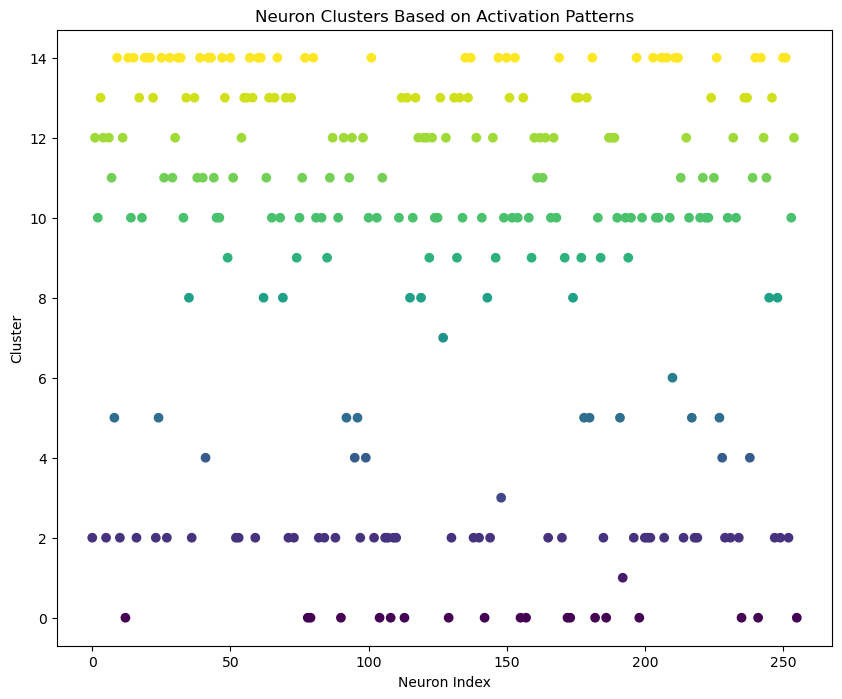

In [ ]:
# Clustering Neurons Based on Activation Patterns
kmeans = KMeans(n_clusters=15)
neuron_clusters = kmeans.fit_predict(combined_activations.numpy().T)

plt.figure(figsize=(10, 8))
plt.scatter(range(len(neuron_clusters)), neuron_clusters, c=neuron_clusters, cmap='viridis')
plt.xlabel("Neuron Index")
plt.ylabel("Cluster")
plt.title("Neuron Clusters Based on Activation Patterns")
plt.show()

# Saliency Map Analysis for Seizure and Non-Seizure Embeddings

In this section, I generate and visualize saliency maps for both seizure and non-seizure embeddings.

Saliency maps highlight the most influential features that contribute to the model's predictions. By analyzing these maps, I can gain insights into which aspects of the embeddings are most relevant for distinguishing between seizure and non-seizure events. This understanding is crucial for interpretability, as it allows me to identify the physiological patterns or neural activity that the model deems important in making its decisions. Such insights could potentially lead to better-informed clinical interventions or the development of more accurate predictive models.


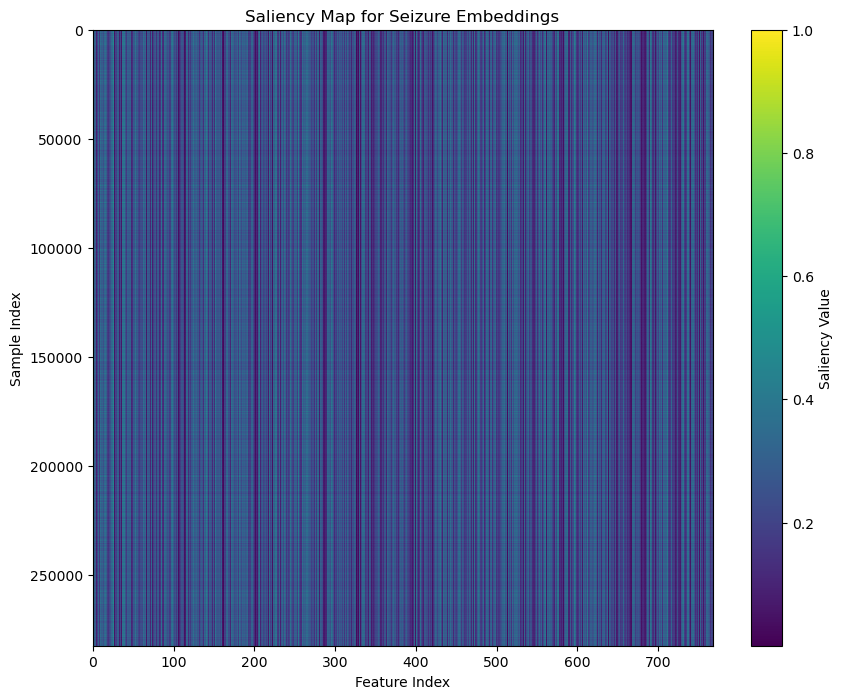

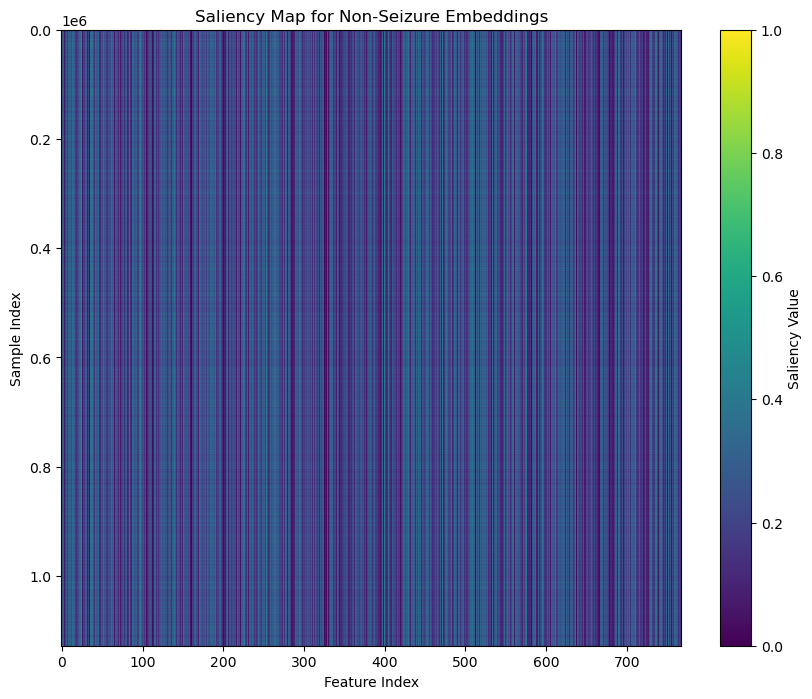

In [ ]:
# Saliency Map Analysis for Seizure and Non-Seizure Embeddings
saliency = Saliency(sparse_autoencoder)
target = 0
batch_size = 128

saliency_map_seizure = []
saliency_map_non_seizure = []

torch.cuda.empty_cache()

for i in range(0, seizure_embeddings.size(0), batch_size):
    batch = seizure_embeddings[i:i + batch_size].to(device)
    batch.requires_grad = True

    with torch.no_grad():
        saliency_map = saliency.attribute(batch, target=target)
        saliency_map_seizure.append(saliency_map.cpu())

for i in range(0, non_seizure_embeddings.size(0), batch_size):
    batch = non_seizure_embeddings[i:i + batch_size].to(device)
    batch.requires_grad = True

    with torch.no_grad():
        saliency_map = saliency.attribute(batch, target=target)
        saliency_map_non_seizure.append(saliency_map.cpu())

saliency_map_seizure = torch.cat(saliency_map_seizure, dim=0)
saliency_map_non_seizure = torch.cat(saliency_map_non_seizure, dim=0)

seiz = saliency_map_seizure.cpu().numpy()
seiz = seiz / np.max(seiz, axis = 0, keepdims=True)
noseiz = saliency_map_non_seizure.cpu().numpy()
noseiz = noseiz / np.max(noseiz, axis = 0, keepdims=True)

plt.figure(figsize=(10, 8))
plt.imshow(seiz, cmap='viridis', aspect='auto')
plt.colorbar(label='Saliency Value')
plt.title('Saliency Map for Seizure Embeddings')
plt.xlabel('Feature Index')
plt.ylabel('Sample Index')
plt.show()

plt.figure(figsize=(10, 8))
plt.imshow(noseiz, cmap='viridis', aspect='auto')
plt.colorbar(label='Saliency Value')
plt.title('Saliency Map for Non-Seizure Embeddings')
plt.xlabel('Feature Index')
plt.ylabel('Sample Index')
plt.show()

# Comparison of Mean Saliency Values
This section compares the mean saliency values for seizure and non-seizure embeddings.

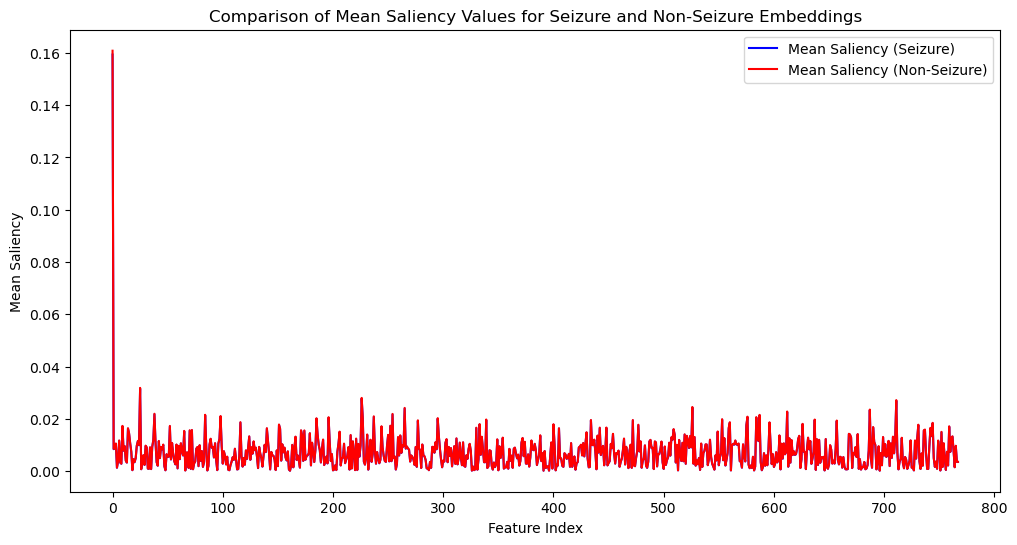

In [ ]:
import matplotlib.pyplot as plt

# Calculate the mean saliency values across all samples for each feature
mean_saliency_seizure = saliency_map_seizure.mean(dim=0).cpu().numpy()
mean_saliency_non_seizure = saliency_map_non_seizure.mean(dim=0).cpu().numpy()

# Plot the mean saliency values
plt.figure(figsize=(12, 6))
plt.plot(mean_saliency_seizure, label='Mean Saliency (Seizure)', color='blue')
plt.plot(mean_saliency_non_seizure, label='Mean Saliency (Non-Seizure)', color='red')
plt.xlabel('Feature Index')
plt.ylabel('Mean Saliency')
plt.title('Comparison of Mean Saliency Values for Seizure and Non-Seizure Embeddings')
plt.legend()
plt.show()


# Difference in Mean Saliency Values

In this section, I calculate and plot the differences in mean saliency values between seizure and non-seizure embeddings.

These differences in mean saliency values prompted me to consider whether they contain valuable information about the key features responsible for distinguishing seizures from non-seizures.


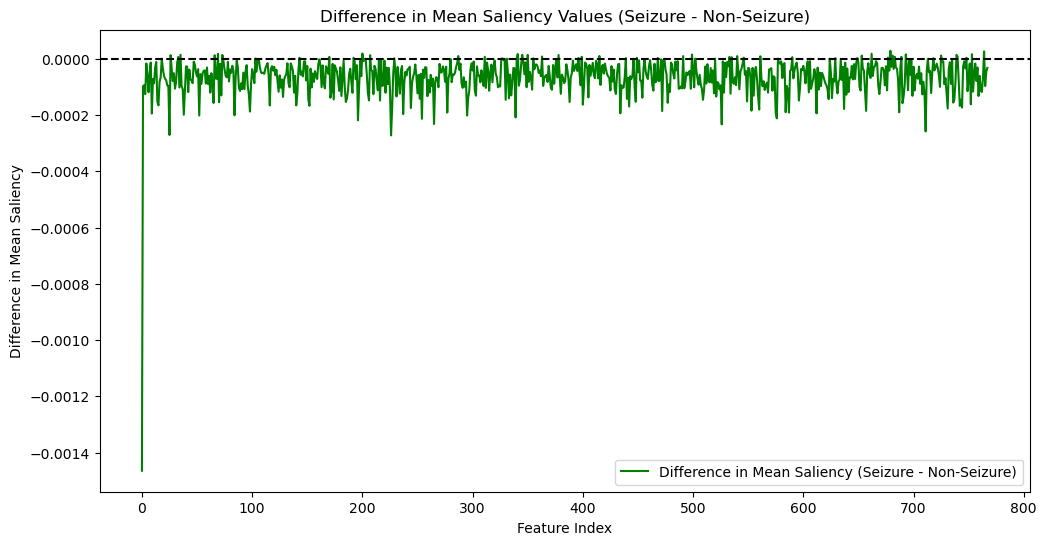

In [ ]:
# Calculate the difference in mean saliency values
difference_mean_saliency = mean_saliency_seizure - mean_saliency_non_seizure

# Plot the difference in mean saliency values
plt.figure(figsize=(12, 6))
plt.plot(difference_mean_saliency, label='Difference in Mean Saliency (Seizure - Non-Seizure)', color='green')
plt.xlabel('Feature Index')
plt.ylabel('Difference in Mean Saliency')
plt.title('Difference in Mean Saliency Values (Seizure - Non-Seizure)')
plt.axhline(0, color='black', linestyle='--')
plt.legend()
plt.show()

# Feature Importance Analysis

Finally, this section identifies the most important features based on the difference in saliency values.

I hypothesize that by exploring the most important features responsible for the differences in these saliency maps, valuable insights can be gained into the features that encode for seizure versus non-seizure data. This analysis could reveal key neural activity patterns that distinguish between these states, contributing to the understanding of the physiological mechanisms underlying seizures.


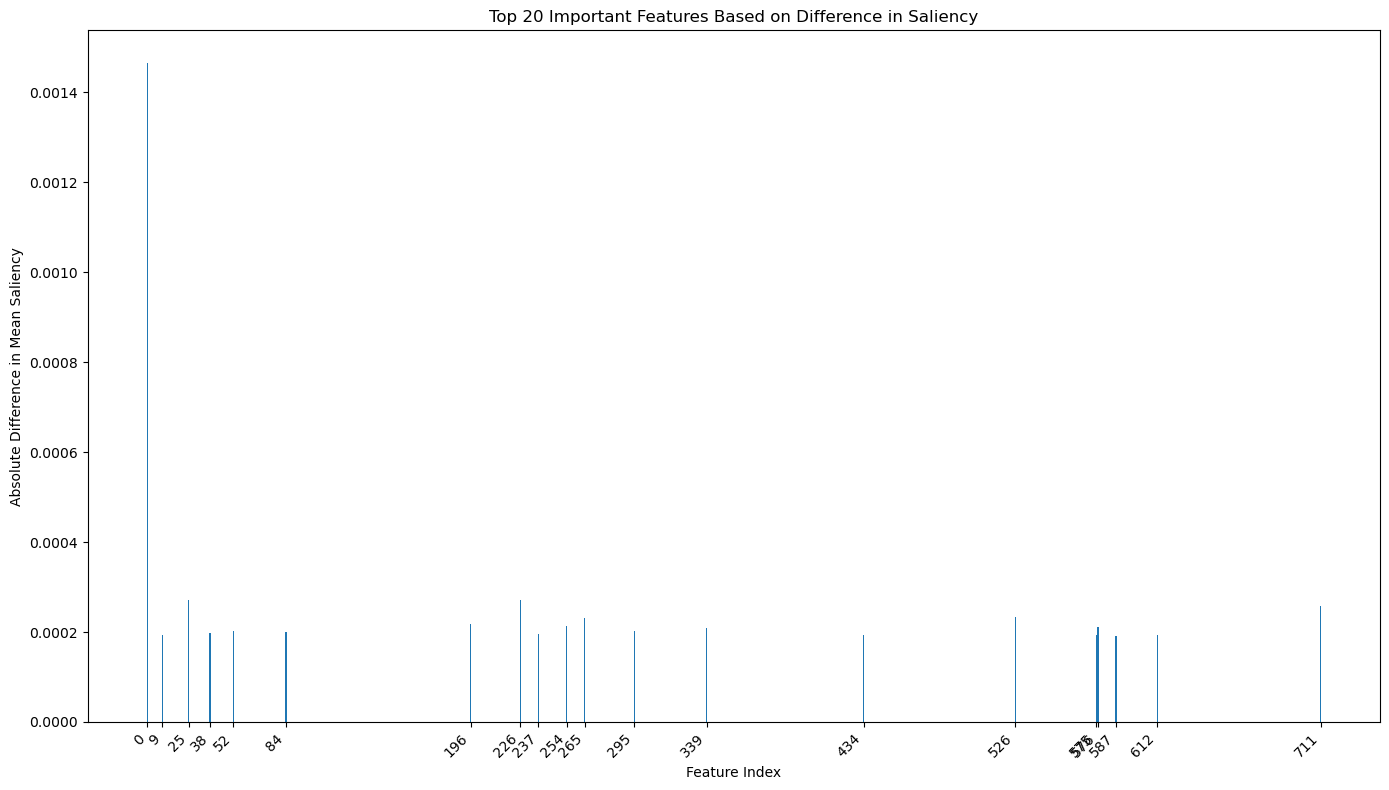

In [ ]:
# Feature Importance Analysis
feature_importance = np.abs(mean_saliency_seizure - mean_saliency_non_seizure)
important_features = np.argsort(feature_importance)[::-1]  # Indices of features sorted by importance

# Limit the number of features displayed (e.g., top 20 features)
top_n = 20
important_features = important_features[:top_n]

# Create a list of feature indices for labeling
feature_indices = np.arange(len(feature_importance))

# Increase figure size and reduce font size for readability
plt.figure(figsize=(14, 8))
plt.bar(feature_indices[important_features], feature_importance[important_features])
plt.xlabel('Feature Index')
plt.ylabel('Absolute Difference in Mean Saliency')
plt.title(f'Top {top_n} Important Features Based on Difference in Saliency')
plt.xticks(ticks=feature_indices[important_features],
           labels=feature_indices[important_features],
           rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels diagonally
plt.tight_layout()  # Adjust layout to make room for the rotated labels
plt.show()
